This code runs Deep Learning on nutau and nue samples created by Dasha. 

This code runs in a python 3.7 conda environment constructed as follows:
- conda create --name tf-gpu tensorflow-gpu keras scikit-learn matplotlib ipykernel nb_conda_kernels [Pillow]
- conda activate tf-gpu
(Pillow is for image manipulation for making heat maps, but I haven't got it to work yet.  Can remove from environment.)

To run with multiple GPUs on CyberLAMP you must specify the "nodes" and "gpus" qualifiers in the same chunk.  For example:
- qsub -I -A cyberlamp -l qos=cl_higpu -l nodes=1:ppn=1:gpus=4:shared -l mem=24gb -l walltime=4:00:00

In [1]:
import os

# Set which GPU to use.  This probably needs to be done before any other CUDA vars get defined.
# Use the command "nvidia-smi" to get association of a particular GPU with a particular number.
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0,2"

In [1]:
from __future__ import division
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from keras import layers
from keras import models
import json

Using TensorFlow backend.


In [3]:
c =0.299792458
n =1.3195
v=c/n 
print(v)

0.2272015596816976


In [5]:
nu_size = 7737578
nu_data = np.memmap('/fastio2/dasha/double_pulse/nu_data.npy', mode = 'r', dtype ='float32', shape = (nu_size,300,60))
nu_info = np.memmap('/fastio2/dasha/double_pulse/nu_info.npy', mode = 'r', dtype ='float32', shape = (nu_size,3))
nu_labels = np.memmap('/fastio2/dasha/double_pulse/nu_label.npy', mode = 'r', dtype ='float32', shape = (nu_size))

In [6]:
print(nu_data[0],nu_info[0],nu_labels[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [23616.275  3619.7    1132.7  ] 0.0


In [10]:
idx = np.arange(nu_size)

In [14]:
nu_e_cc_data = []
nu_m_cc_data = []
nu_t_cc_data = []
nu_nc_data = []
nu_e_cc_info = []
nu_m_cc_info = []
nu_t_cc_info = []
nu_nc_info = []

for i in idx:
    if (nu_info[i][0] >500000) and (nu_info[i][0] <1500000):
        if (nu_labels[i] == 0):
            nu_e_cc_data.append(nu_data[i])
            nu_e_cc_info.append(nu_info[i])
        elif (nu_labels[i] == 2):
            nu_m_cc_data.append(nu_data[i])
            nu_m_cc_info.append(nu_info[i])
        elif (nu_labels[i] == 4):
            nu_t_cc_data.append(nu_data[i])
            nu_t_cc_info.append(nu_info[i])
        else:
            nu_nc_data.append(nu_data[i])
            nu_nc_info.append(nu_info[i])

nu_e_cc_data = np.array(nu_e_cc_data)
nu_m_cc_data = np.array(nu_m_cc_data)
nu_t_cc_data = np.array(nu_t_cc_data)
nu_nc_data = np.array(nu_nc_data)
nu_e_cc_info = np.array(nu_e_cc_info)
nu_m_cc_info = np.array(nu_m_cc_info)
nu_t_cc_info = np.array(nu_t_cc_info)
nu_nc_info = np.array(nu_nc_info)

In [15]:
print(nu_e_cc_data.shape, nu_e_cc_info.shape)
print(nu_m_cc_data.shape, nu_m_cc_info.shape)
print(nu_t_cc_data.shape, nu_t_cc_info.shape)
print(nu_nc_data.shape, nu_nc_info.shape)


(263749, 300, 60) (263749, 3)
(587588, 300, 60) (587588, 3)
(109487, 300, 60) (109487, 3)
(133914, 300, 60) (133914, 3)


In [17]:
np.save("NuE_CC_05to15_info.npy",nu_e_cc_info)

In [18]:
np.save("NuMu_CC_05to15_info.npy",nu_m_cc_info)

In [19]:
np.save("NuTau_CC_05to15_info.npy",nu_t_cc_info)

In [20]:
np.save("Nu_NC_05to15_info.npy",nu_nc_info)

In [ ]:
np.save("NuE_CC_05to15_data.npy",nu_e_cc_data)

In [ ]:
np.save("NuMu_CC_05to15_data.npy",nu_m_cc_data)

In [ ]:
np.save("NuTau_CC_05to15_data.npy",nu_t_cc_data)

In [ ]:
np.save("Nu_NC_05to15_data.npy",nu_nc_data)

In [26]:
try_d = np.load("../../data/new_data05to15/Nu_NC_05to15_data.npy")
try_i = np.load("../../data/new_data05to15/Nu_NC_05to15_info.npy")

[822630.25    5108.65    4464.875]


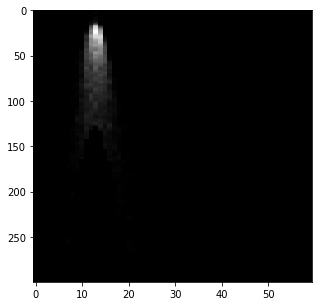

In [27]:
print(try_i[0])
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.imshow(try_d[0], interpolation='nearest', aspect='auto', cmap= 'gray')

In [7]:
data_s = np.load("../../data/new_data05to15/NuE_CC_05to15_data.npy")
data_d = np.load("../../data/new_data05to15/NuTau_CC_05to15_data.npy")

In [4]:
info_s = np.load("../../data/new_data05to15/NuE_CC_05to15_info.npy")
info_d = np.load("../../data/new_data05to15/NuTau_CC_05to15_info.npy")
info = np.concatenate((info_d, info_s), axis = 0) 


In [5]:
print(info[:10])

[[1.0763715e+06 3.7816750e+03 3.2907500e+03]
 [1.3544724e+06 1.3178000e+04 9.8838750e+03]
 [7.0618569e+05 4.5050324e+04 3.2292875e+04]
 [8.5488556e+05 5.7408227e+04 3.0946426e+04]
 [1.3259894e+06 2.5790900e+04 2.5577301e+04]
 [1.0354069e+06 5.0344926e+04 3.7202273e+04]
 [6.8200231e+05 2.3042500e+03 1.2208250e+03]
 [7.1232019e+05 4.7930249e+03 3.4059751e+03]
 [9.3046400e+05 4.9353125e+04 3.5844000e+04]
 [7.9987631e+05 5.2154502e+03 1.1775250e+03]]


In [8]:
label_d = [[0,1]]*len(data_d)
label_s = [[1,0]]*len(data_s)
label_d = np.array(label_d)
label_s = np.array(label_s)
print(label_d.shape)
print(label_s.shape)
print(label_d[0])
print(label_s[0])
print(data_s.shape, data_d.shape)

(109487, 2)
(263749, 2)
[0 1]
[1 0]
(263749, 300, 60) (109487, 300, 60)


In [9]:
data = np.concatenate((data_d, data_s), axis = 0) 
label = np.concatenate((label_d, label_s), axis = 0) 
data, label = shuffle(data, label, random_state =12)

train_data = data[:250000]
train_label = label[:250000]
train_data = train_data.reshape((len(train_data),300,60,1))
train_data = train_data.astype('float32')/10**-8
mean = np.mean(train_data)
std = np.std(train_data)
print(mean,std)
train_data = train_data - mean
train_data = train_data/std

valid_data = data[250000:300000]
valid_label = label[250000:300000]
valid_data = valid_data.reshape((len(valid_data),300,60,1))
valid_data = valid_data.astype('float32')/10**-8
valid_data = valid_data - mean
valid_data = valid_data/std

test_data = data[300000:]
test_label = label[300000:]
test_data = test_data.reshape((len(test_data),300,60,1))
test_data = test_data.astype('float32')/10**-8
test_data = test_data - mean
test_data = test_data/std


0.0013148792 0.015230651


In [10]:
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)
print(valid_data.shape, valid_label.shape)


(250000, 300, 60, 1) (250000, 2)
(73236, 300, 60, 1) (73236, 2)
(50000, 300, 60, 1) (50000, 2)


In [ ]:
data_s_1 = np.load("../../data/new_data05to15/Nu_NC_05to15_data.npy")
data_s_2 = np.load("../../data/new_data05to15/NuE_CC_05to15_data.npy")
data_s = np.concatenate((data_s_1, data_s_2), axis = 0) 